# Lesson 6: Information Theory

References

My Statistics learning notebook following the live lesson series [**"Probability and Statistics for Machine Learning"**](https://learning.oreilly.com/videos/probability-and-statistics/9780137566273/) by Dr. Jon Krohn. I adapted some and partially modified or added entirely new code. Notes largely based on and from Jon's notebooks and learning materials. The lesson and original notebook source code at:

https://learning.oreilly.com/videos/probability-and-statistics/9780137566273/
https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb

## Basic Setup

In [2]:
import math
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import cv2
from IPython.display import HTML, display
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('here')

def set_css():
  display(HTML('''<style> pre { white-space: pre-wrap; } </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

# Shows the image immediately. 
# Resize option available.
# If you are using others' image, you can pass in a string parameter to cite the source.
def show_img(path, resize=None, source=None, source_scale=0.5):
    img = cv2.imread(path)
    if (resize != None):
        img = cv2.resize(img, dsize=(0,0), fx=resize, fy=resize)
    if(source != None):
        cite_source(img, source, scale=source_scale)
    cv2_imshow(img)

# Turns the path into an image object. Resize option available.
def get_img(path, resize=None):
  img = cv2.imread(path)
  if (resize != None):
    img = cv2.resize(img, dsize=(0,0), fx=resize, fy=resize)
  return img

# Puts text of source on the image.
# Avoiding plagiarism and crediting others' hard work is important.
def cite_source(img, source, org=None, scale=0.7, color=1):
    if (org == None):
        img = cv2.putText(img, source, org=(int(np.ceil(img.shape[1]*0.1)), int(np.ceil(img.shape[0]*0.98))),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=1)
    elif (org != None):
        img = cv2.putText(img, source, org=org,
                          fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=scale, color=1)
    return img

# Take notes on a sticky note.
def take_notes(img, source, org, scale=None, color=1, thickness=1):
    if (org == None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * 0.9 )), int(np.ceil( img.shape[0] * 0.1 )) ),
                          fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=scale, color=color, thickness=thickness)
    elif (org != None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * org[0] )), int(np.ceil( img.shape[0] * org[1] )) ),
                          fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=scale, color=color, thickness=thickness)
    return img

def sticky_notes(notes, return_object=False):
    path = "/content/here/MyDrive/Math works/notes.png"    
    sticky_notes = get_img(path, resize=0.65)

    for i, note in enumerate(notes):
        sticky_notes = take_notes(sticky_notes, note, org=(1/17,(i+4)/11), scale=0.5)
    if (return_object == True):
        return sticky_notes
    else:
        cv2_imshow(sticky_notes)

# Code by Bill Grates on Stackoverflow
# https://stackoverflow.com/users/5629538/bill-grates
# https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

Mounted at here


## Sticky Notes for Thoughts

In [ ]:
# display work
notes = ["",
         "",
         "",
         ""]

sticky_notes(notes)

# 6.1 What Information Theory Is
- Field of applied mathematics
- While Probability Theory facilitates uncertain statements and reasoning despite the uncertainty, Informatino Theory quantifies the uncertainty in a signal (e.g. a distribution).
- Claude Shannon (1916-2001): father of Info. thy.

# 6.2 Self-Information, Nats, and Bits
The eesnetial concept: 
- Likelier events have less information content than rarer ones. 
  - Message that sun rose this morning has no niformational value. 
- The equation of **self-information**: 
$$I(x) = -logP(x)$$
  - Self-information of a RV $x$: $(I(x))$
  - is equal tot he logarithm of the probability of that event $x$ ($-logP(x)$)
  - Quantifies the informational content.
    - If event is guaranteed (i.e., $P(x)=1$), $I(x)=0$
    - Less likely an event, the greater $I(x)$
    - Independent events are additive. 
      - If one head flip has $I(x)$, two heads flips has 2$I(x)$

In [3]:
def self_info(p):
    return -1 * np.log(p)   # nats

In [6]:
probs = [1, 0.5, 0.1, 0.01]

for prob in probs: 
    print(self_info(prob))

# the smaller the probability, the greater the entropy is.

-0.0
0.6931471805599453
2.3025850929940455
4.605170185988091


In [7]:
self_info(0.5) + self_info(0.5)

1.3862943611198906

Depending on what logarithm base we use, the units of self-information vary. Most frequently, the units are either:

nats:  
- Natural logarithm, as above with `np.log()`
- Typical in ML  

bits:  
- Base-2 logarithm
- A.k.a. shannons
- Typical in computer science

So, the self-information of $P(x) = 0.1$ is ~2.3 nats.


# 6.3 Shannon and Differential Entropy

To quantify uncertainty about a probability distribution (as opposed to a single event), we can use Shannon entropy, which is denoted $H(x)$ or $H(P)$: $$ H(x) = \mathbb{E}_{\text{x}\sim P}[I(x)] \\ = -\mathbb{E}_{\text{x}\sim P}[\text{log}P(x)] $$

Conveys the expected informational content associated with an event drawn from the distribution:

**Low entropy**:
- Distribution is ~deterministic and outcomes are ~certain
- E.g., weighted coin always lands heads up ($P(1)=1$)

**High entropy**:
- Outcomes are uncertain
- Uniform distribution can be highest entropy
- E.g., coin is as likely to be heads as tails ($P(0)=P(1)=0.5$)

As an example, Shannon entropy for a binary random variable (e.g., coin flip) is: $$ (p-1)\text{log}(1-p)-p \text{log}p $$

In [8]:
def binary_entropy(p):
    return (p-1) * np.log(1-p) - p * np.log(p)

Will throw nan with $p=0$ (always tails) or $p=1$ (always heads), but we can get close:

In [16]:
probs = [0.00001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.99999]

for prob in probs:
    print(f'{prob} entropy: {binary_entropy(prob)}')

1e-05 entropy: 0.00012512920464949012
0.001 entropy: 0.007907255112232087
0.1 entropy: 0.3250829733914482
0.5 entropy: 0.6931471805599453
0.7 entropy: 0.6108643020548935
0.9 entropy: 0.3250829733914482
0.99999 entropy: 0.00012512920464901166


In [23]:
max_H = np.max(H)
max_H

0.6931466815603623

## **Differential entropy**
- simply the term for Shannon entropy if distribution is PDF.
- used to calculate a single distribution. 

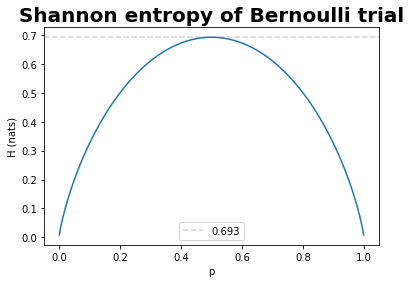

In [26]:
p = np.linspace(0.001, 0.999, 1000)
H = binary_entropy(p)

fig, ax = plt.subplots()
plt.title('Shannon entropy of Bernoulli trial', fontsize=20, fontweight='bold')
plt.axhline(max_H, linestyle='dashed', color='lightgray', label=np.round(max_H, 3))
plt.xlabel('p')
plt.ylabel('H (nats)')
plt.legend()
_ = ax.plot(p,H)

# 6.4 Kullback-Leibler Divergence and Cross-Entropy

If we want to compare two different distributions...

## **KL divergence** 
: enables us to quantify the relative Shannon (or differential) entropy of two probability distributions that are over the same random variable x.

For example, if we have one probability distribution described by $P(x)$ and another by $Q(x)$, their KL divergence (denoted $D_\text{KL}$) is: $$ D_\text{KL}(P||Q) = \mathbb{E}_{\text{x} \sim P}[\text{log}P(x) - \text{log}Q(x)] $$

- This is simply comparing the self-information. 



## **Cross-Entropy**

Cross-entropy is a concept derived from KL divergence. Its detail is beyond the scope of this series except to mention that it provides us with the cross-entropy cost function.

This cost function is ubiquitous in neural networks as it's the cost function of choice for predicting discrete, categorical outcomes. E.g., for a binary classifier, the cross-entropy cost ($C$) is:
$$ C = -(y \cdot \text{log}(\hat{y}) + (1-y) \cdot \text{log}(1-\hat{y})) $$


- it's the cost function of choice for a neural network or a deep learning network tasked with predicting **discrete categorical outcomes**. 

In [28]:
# y = true known output
# y_hat = prediction

def cross_entropy(y, y_hat):    
    return -1 * (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

In [30]:
# Positive movie review? 
# Cross entropy is low when the model's prediction is close to the desired output.

cross_entropy(1, 0.997)

0.0030045090202987243

In [35]:
preds = [0.9997, 0.997, 0.9, 0.6, 0.3, 0.1, 0.001, 0.00001]

print('Prediction Cross Entropy when:')
for pred in preds: 
    print(f'pred = {pred}:  {np.round(cross_entropy(1, pred), 3)}')

Prediction Cross Entropy when:
pred = 0.9997:  0.0
pred = 0.997:  0.003
pred = 0.9:  0.105
pred = 0.6:  0.511
pred = 0.3:  1.204
pred = 0.1:  2.303
pred = 0.001:  6.908
pred = 1e-05:  11.513
